Train shape: (401125, 53)
Test shape : (12457, 52)
                                                                                                    
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
                                                                                                    


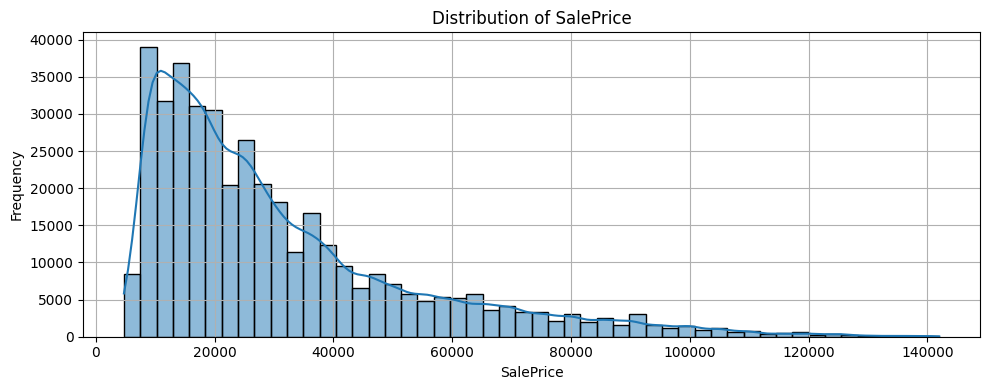

                                                                                                    
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
                                                                                                    


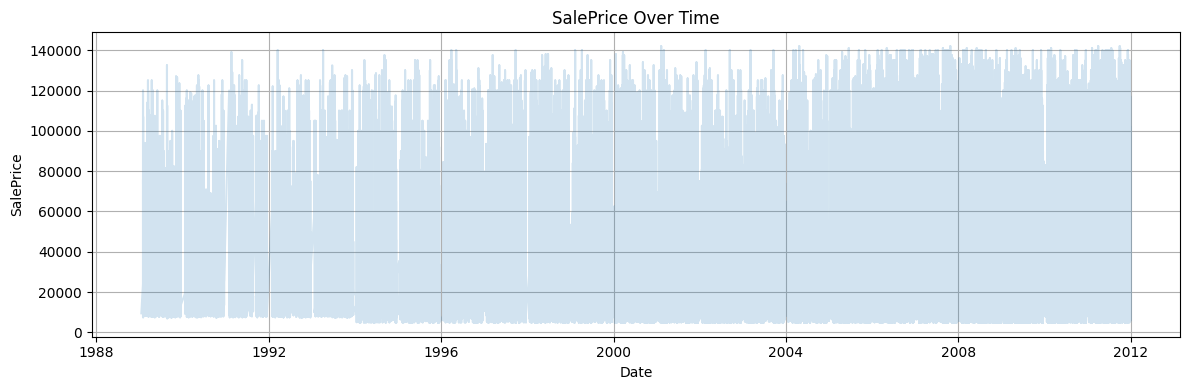

                                                                                                    
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
                                                                                                    


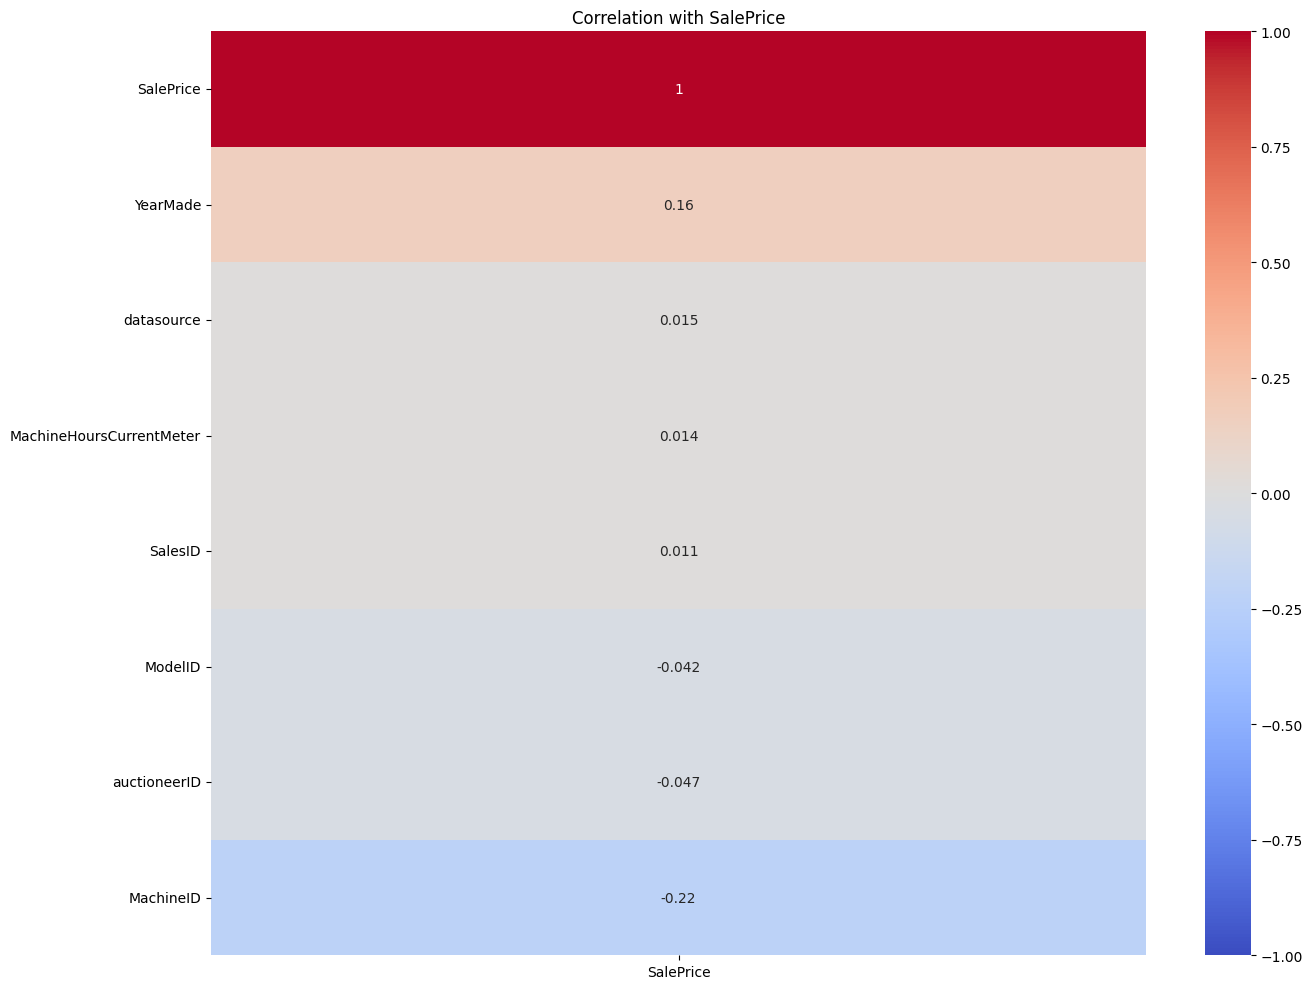

✅ Validation RMSLE: 0.2654
✅ Submission file saved: /content/test_predictions.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

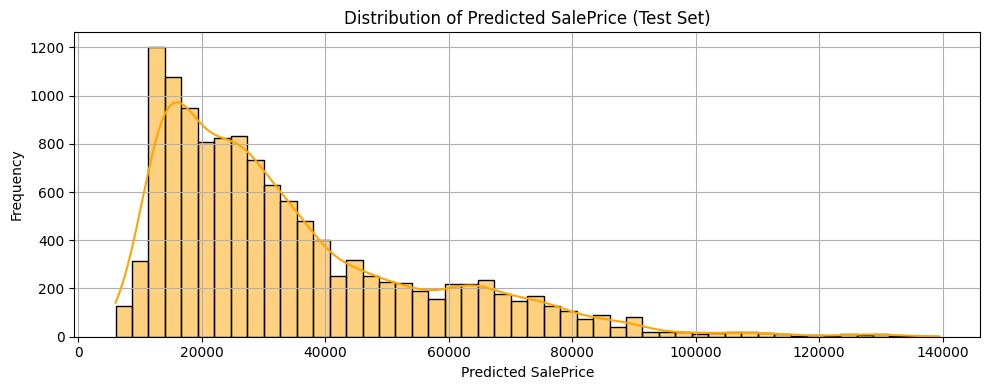

                                                                                                    
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
                                                                                                    


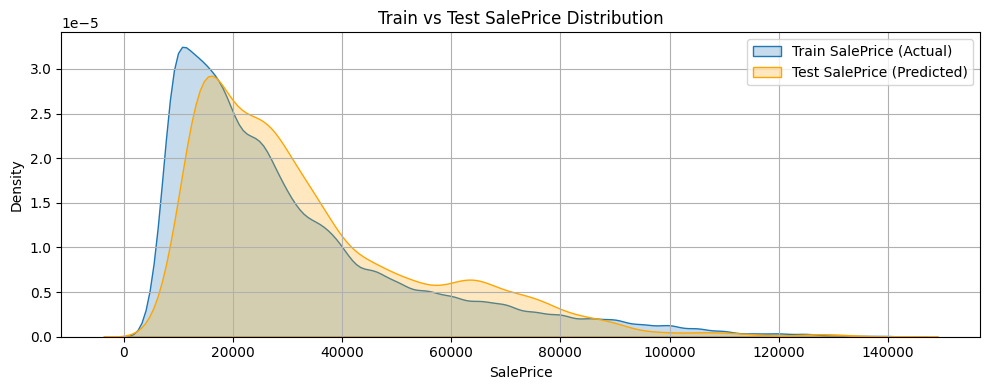

                                                                                                    
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
                                                                                                    


<ipython-input-1-47473963>:183: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="SalesID", y="SalePrice", data=top20, palette="coolwarm")


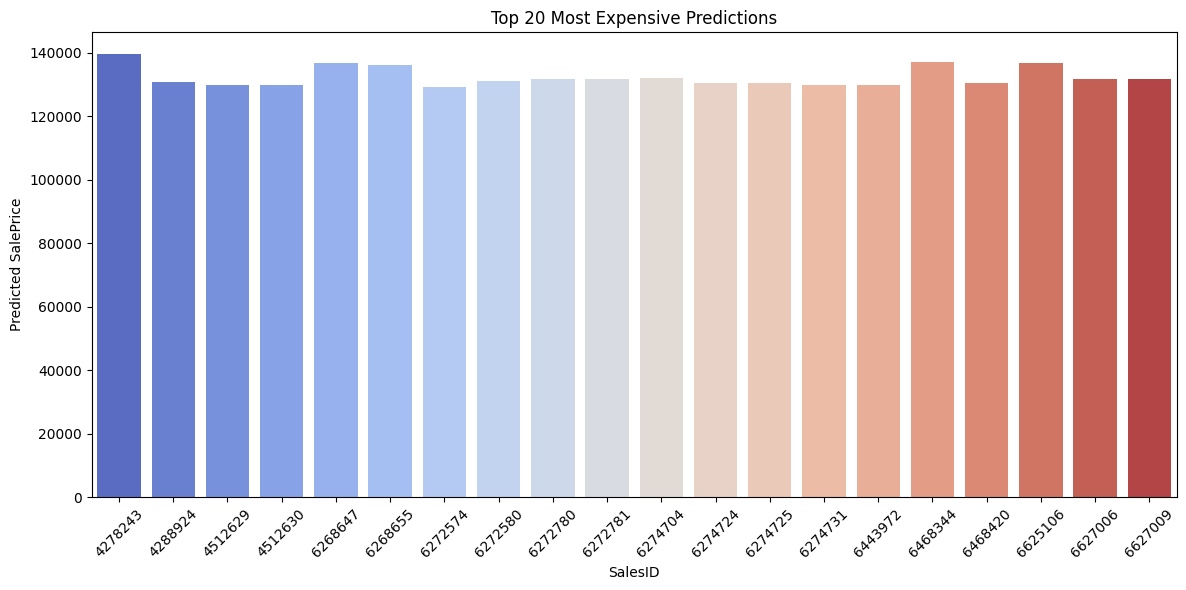

                                                                                                    
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
                                                                                                    


In [1]:
# === STEP 0: Unzip the dataset ===
import zipfile, os

zip_path = "/content/datasheet.zip"
extract_path = "/content/bluebook_data"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# === STEP 1: Imports ===
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# === STEP 2: Load the data ===
train = pd.read_csv(f'{extract_path}/bluebook-for-bulldozers/Train.csv', low_memory=False)
test = pd.read_csv(f'{extract_path}/bluebook-for-bulldozers/Test.csv', low_memory=False)

print("Train shape:", train.shape)
print("Test shape :", test.shape)
print(" "*100)
print("-"*100)
print("-"*100)
print("-"*100)
print(" "*100)

# === STEP 3: EDA – Visualizations ===
train['saledate'] = pd.to_datetime(train['saledate'])

# Distribution of SalePrice
plt.figure(figsize=(10, 4))
sns.histplot(train['SalePrice'], bins=50, kde=True)
plt.title("Distribution of SalePrice")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

print(" "*100)
print("-"*100)
print("-"*100)
print("-"*100)
print(" "*100)

# SalePrice over time
plt.figure(figsize=(12, 4))
train.sort_values("saledate", inplace=True)
plt.plot(train["saledate"], train["SalePrice"], alpha=0.2)
plt.title("SalePrice Over Time")
plt.xlabel("Date")
plt.ylabel("SalePrice")
plt.grid(True)
plt.tight_layout()
plt.show()

print(" "*100)
print("-"*100)
print("-"*100)
print("-"*100)
print(" "*100)

# Correlation heatmap (numeric only)
plt.figure(figsize=(14, 10))
numeric_corr = train.select_dtypes(include='number').corr()
sns.heatmap(numeric_corr[['SalePrice']].sort_values(by='SalePrice', ascending=False), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation with SalePrice")
plt.tight_layout()
plt.show()

# === STEP 4: Drop high-missing columns ===
drop_cols = train.columns[train.isnull().mean() > 0.5]
train.drop(columns=drop_cols, inplace=True)
test.drop(columns=drop_cols, inplace=True, errors='ignore')

# === STEP 5: Fill missing values ===
for col in train.columns:
    if train[col].dtype == 'object':
        train[col] = train[col].fillna(train[col].mode()[0])
    else:
        train[col] = train[col].fillna(train[col].median())

for col in test.columns:
    if test[col].dtype == 'object':
        test[col] = test[col].fillna(test[col].mode()[0])
    else:
        test[col] = test[col].fillna(test[col].median())

# === STEP 6: Feature Engineering – Date features ===
test['saledate'] = pd.to_datetime(test['saledate'])
train['saleYear'] = train['saledate'].dt.year
train['saleMonth'] = train['saledate'].dt.month
test['saleYear'] = test['saledate'].dt.year
test['saleMonth'] = test['saledate'].dt.month
train.drop('saledate', axis=1, inplace=True)
test.drop('saledate', axis=1, inplace=True)

# === STEP 7: Label Encoding (combined train + test) ===
cat_cols = train.select_dtypes(include='object').columns

for col in cat_cols:
    le = LabelEncoder()
    combined = pd.concat([train[col], test[col]], axis=0).astype(str)
    le.fit(combined)

    train[col] = le.transform(train[col].astype(str))
    if col in test.columns:
        test[col] = le.transform(test[col].astype(str))

# === STEP 8: Prepare Features ===
X = train.drop(columns=['SalePrice'])
y = train['SalePrice']
X_test = test[X.columns]  # Ensure same column order

# === STEP 9: Train/Validation Split ===
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# === STEP 10: Train Model ===
model = RandomForestRegressor(n_estimators=100, max_depth=15, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

# === STEP 11: Evaluate ===
val_preds = model.predict(X_val)
rmsle = np.sqrt(mean_squared_log_error(y_val, val_preds))
print(f"✅ Validation RMSLE: {rmsle:.4f}")

# === STEP 12: Predict on Test Set ===
model.fit(X, y)
test_preds = model.predict(X_test)

submission = pd.DataFrame({
    'SalesID': test['SalesID'],
    'SalePrice': test_preds
})
submission_path = "/content/test_predictions.csv"
submission.to_csv(submission_path, index=False)
print("✅ Submission file saved:", submission_path)

# === STEP 13: Download Submission CSV ===
files.download(submission_path)
# === STEP 14: Visualizations of Final Results ===

# 1. Distribution of test predictions
plt.figure(figsize=(10, 4))
sns.histplot(test_preds, bins=50, kde=True, color='orange')
plt.title("Distribution of Predicted SalePrice (Test Set)")
plt.xlabel("Predicted SalePrice")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()
print(" "*100)
print("-"*100)
print("-"*100)
print("-"*100)
print(" "*100)

# 2. Train vs Test prediction distribution comparison
plt.figure(figsize=(10, 4))
sns.kdeplot(y, label='Train SalePrice (Actual)', fill=True)
sns.kdeplot(test_preds, label='Test SalePrice (Predicted)', fill=True, color='orange')
plt.title("Train vs Test SalePrice Distribution")
plt.xlabel("SalePrice")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print(" "*100)
print("-"*100)
print("-"*100)
print("-"*100)
print(" "*100)

# 3. Top 20 most expensive predicted machines
top20 = submission.sort_values(by='SalePrice', ascending=False).head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x="SalesID", y="SalePrice", data=top20, palette="coolwarm")
plt.title("Top 20 Most Expensive Predictions")
plt.xticks(rotation=45)
plt.ylabel("Predicted SalePrice")
plt.tight_layout()
plt.show()
print(" "*100)
print("-"*100)
print("-"*100)
print("-"*100)
print(" "*100)
